# CMIP6 Historical model runs
- opens all the CMIP6 historical model run files with data on precipitation pr and surface temperature tas
- calculates monthly anomalies (based on 1850-1880 climatology) for 4 spatial regions (global, SH, Aus, E Aus)
- calculates percentiles (10, 90) to show model spread
- plots a time series of tas and pr results from 1850-2015

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 

In [4]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5

v20200302


In [5]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


## Read in model data

In [6]:
models_tas = funcM.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [7]:
models_pr = funcM.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [8]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [9]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.04 GB,1.38 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,36929 Tasks,7260 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.07 GB,2.76 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,45181 Tasks,7260 Chunks
Type,float64,numpy.ndarray


In [10]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [11]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [12]:
# area weighting 
models_w = models*np.cos(models_tas.lat*(np.pi/180))

In [13]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-01-01 01:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 01:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axi

In [17]:
# group the data by month and take the 
monthly_raw_glob = models_w.groupby('time.month').mean(dim=['lat','lon'])
min_raw_glob = monthly_raw_glob.min(dim=['model'])
max_raw_glob = monthly_raw_glob.max(dim=['model'])
range_raw_glob = max_raw_glob - min_raw_glob

In [20]:
# find the range of the model spread for each month in the time period (then can plot a time series of model range)
def model_spread(dataset_raw):
    """Finds the range of the model spread at each time point for the variables in the raw dataset.   
    Args:
        dataset_raw (xarray dataset): raw values of variables
    """
    monthly_raw_ds = dataset_raw.groupby('time.month').mean(dim=['lat','lon'])
    min_raw_ds = monthly_raw_ds.min(dim=['model'])
    max_raw_ds = monthly_raw_ds.max(dim=['model'])
    range_raw_ds = max_raw_ds - min_raw_ds
    
    return range_raw_ds

In [21]:
# select out the raw data for each region
models_w_SH = models_w.sel(lat=slice(-90,0)) 
models_w_Aus = models_w.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
models_w_EA = models_w.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

In [22]:
# find the model range for each spatial region 
model_spread_Glob = model_spread(models_w)
model_spread_SH = model_spread(models_w_SH)
model_spread_Aus = model_spread(models_w_Aus)
model_spread_EA = model_spread(models_w_EA)

In [26]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [27]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

In [28]:
# select out years surrounding Krakatoa eruption
K_model_spread_Glob = model_spread_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_model_spread_SH = model_spread_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_model_spread_Aus = model_spread_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_model_spread_EA = model_spread_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

## Figures

In [24]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

[########################################] | 100% Completed |  7min 17.4s
[########################################] | 100% Completed |  6min 52.4s
[########################################] | 100% Completed |  6min 33.8s
[########################################] | 100% Completed |  6min 50.0s


NameError: name 'deg' is not defined

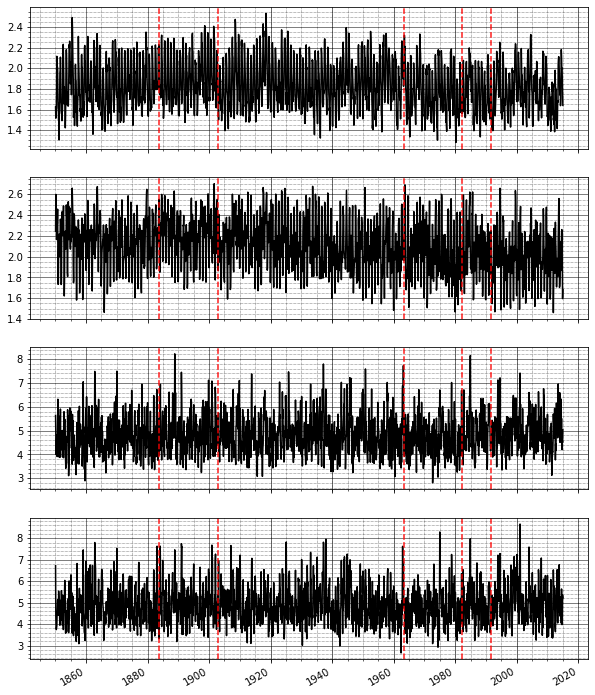

In [23]:
# Model spread of temperature for all regions
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(model_spread_Glob.tas, ax = axes[0], color='lightcoral')
    fplot.timeseries_graph(model_spread_SH.tas, ax = axes[1], color='lightcoral')
    fplot.timeseries_graph(model_spread_Aus.tas, ax = axes[2], color='lightcoral')
    fplot.timeseries_graph(model_spread_EA.tas, ax = axes[3], color='lightcoral')

axes[0].set(ylabel= f'Model range of temperature [{deg}C]', title = 'Global') 
axes[1].set(ylabel= f'Model range of temperature [{deg}C]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Model range of temperature [{deg}C]', title = 'Australia')
axes[3].set(ylabel= f'Model range of temperature [{deg}C]', title = 'Eastern Australia')

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('time_series_model_range_tas.png', dpi=300, bbox_inches='tight')

In [ ]:
# Model spread of rainfall for all regions
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(model_spread_Glob.pr, ax = axes[0], color='mediumaquamarine', fontsize=14)
    fplot.timeseries_graph(model_spread_SH.pr, ax = axes[1], color='mediumaquamarine')
    fplot.timeseries_graph(model_spread_Aus.pr, ax = axes[2], color='mediumaquamarine')
    fplot.timeseries_graph(model_spread_EA.pr, ax = axes[3], color='mediumaquamarine')

axes[0].set(ylabel= f'Model range of rainfall [mm/day]', title = 'Global', size=14) 
axes[1].set(ylabel= f'Model range of rainfall [mm/day]', title = 'Southern Hemisphere', size=14)
axes[2].set(ylabel= f'Model range of rainfall [mm/day]', title = 'Australia', size=14)
axes[3].set(ylabel= f'Model range of rainfall [mm/day]', title = 'Eastern Australia', size=14)

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('time_series_model_range_pr.png', dpi=300, bbox_inches='tight')

In [30]:
# use this to set the x-ticks for each month from 5 years before to 5 years after the eruption
months = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='MS')
years = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='YS')

# x ticks are not quite working properly
# might need to zoom in on just 5 years 

In [40]:
# set the default font size for each of 
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

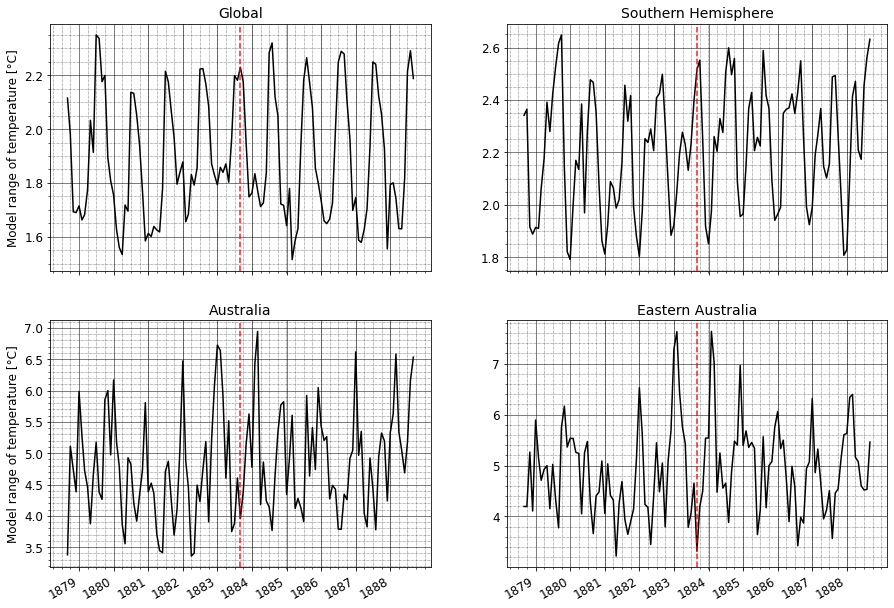

In [41]:
# Monthly model range of temperature for years surrounding Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_model_spread_Glob.tas, ax = axes[0,0],color='lightcoral')
fplot.timeseries_graph(K_model_spread_SH.tas, ax = axes[0,1], color='lightcoral')
fplot.timeseries_graph(K_model_spread_Aus.tas, ax = axes[1,0], color='lightcoral')
fplot.timeseries_graph(K_model_spread_EA.tas, ax = axes[1,1], color='lightcoral')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Model range of temperature [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Model range of temperature [{deg}C]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

#fig.tight_layout() # stops things from overlapping and makes the figure more compact

plt.savefig('K_timeseries_model_range_tas.png', dpi=300, bbox_inches='tight')

In [ ]:
# Monthly model range of rainfall for years surrounding Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_model_spread_Glob.pr, ax = axes[0,0],color='mediumaquamarine')
fplot.timeseries_graph(K_model_spread_SH.pr, ax = axes[0,1], color='mediumaquamarine')
fplot.timeseries_graph(K_model_spread_Aus.pr, ax = axes[1,0], color='mediumaquamarine')
fplot.timeseries_graph(K_model_spread_EA.pr, ax = axes[1,1], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Model range of rainfall [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Model range of rainfall [mm/day]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

#fig.tight_layout() # stops things from overlapping and makes the figure more compact

plt.savefig('K_timeseries_model_range_pr.png', dpi=300, bbox_inches='tight')